## Content:
- **[Part 1](#part1)- Importing the data set, packages used**
- **[Part 2](#part2)- Preprocessing Data and feature engineering**
- **[Part 3](#part3) - Logistic Regression**
- **[Part 4](#part4) - ANN with one Hidden Layer**
- **[Part 5](#part5) - ANN with two Hidden Layers**
- **[Part 6](#part6) - ANN with three Hidden Layers**



We will build on our results and use regression with reduced number of features

[Back to top](#Content:)


<a id='part1'></a>

# Part 1 -  Importing the data set

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
%matplotlib inline

In [2]:
random.seed(0)

In [3]:
# Loading Dataset
df = pd.read_csv("healthcare/train_data.csv", na_values=['NA', '?'])

In [4]:
# Dropping na values for 
df = df.dropna()

In [5]:
df.columns

Index(['case_id', 'Hospital_code', 'Hospital_type_code', 'City_Code_Hospital',
       'Hospital_region_code', 'Available Extra Rooms in Hospital',
       'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade',
       'patientid', 'City_Code_Patient', 'Type of Admission',
       'Severity of Illness', 'Visitors with Patient', 'Age',
       'Admission_Deposit', 'Stay'],
      dtype='object')

In [6]:
# Dropping case_id, Ward Facility code , Hospital Region code , Hospital Type Code
df.drop(['case_id', 'Hospital_type_code','Hospital_region_code','Ward_Facility_Code' ], axis=1, inplace=True)

[Back to top](#Content:)


<a id='part2'></a>

# Part 2 -  Preprocessing Data and feature engineering

## Feature engineering 

We add the feature New Patient

In [7]:
n = df.shape[0]
visits = []
patientid = np.array(df['patientid'])
df['New Patient'] = 0
for i in range(1,n) :
    df['New Patient'][i] = (patientid[i] in patientid[:i])*1
   


/Users/baraa/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Hot Encoded Data

In [8]:
# Function to hot encode the column with name : name for dataframe df
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True) 

In [9]:
from sklearn.preprocessing import LabelEncoder 
# Columns where we use Label Encoding
le_string_columns = ['Severity of Illness', 'Age' ]
# Columns where we use One Hot Encoding
dummies_string_columns = ['Department', 'Ward_Type',  'Type of Admission']
encoder = LabelEncoder()

## label_encoded data
Xe = df.drop(['Stay', 'patientid'], axis=1)
Xe['Severity of Illness']= Xe['Severity of Illness'].map({'Minor': 0,  'Moderate': 1,'Extreme': 2})
Xe['Age'] = encoder.fit_transform(Xe['Age'])

ye = df['Stay']
ye = encoder.fit_transform(ye)

for column in dummies_string_columns :
    encode_text_dummy(Xe, column)
    

### Scaling and splitting Data

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X = Xe.values
y = ye
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
for i in range(X_train.shape[1]) :
    X_train[:,i]= scaler.fit_transform(X_train[:,i].reshape(-1, 1))[:,0]
    X_test[:,i] = scaler.transform(X_test[:,i].reshape(-1, 1))[:,0]

### Scoring

In [11]:
K = 10 # Num of Classes 
# Classes can be ranked here from 0-10
def score(pred, target):
    error = (np.mean(np.abs(pred-target)))/K
    score = 1 - error
    return score

# Models

We start by a base model, models used here are that are most adapted to the nature of the problem :
- Linear Regression
- Lasso Regression
- One Hidden Layer ANN
- Two Hidden Layer ANN


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

[Back to top](#Content:)


<a id='part3'></a>

# Part 3 -  Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegressionCV

In [14]:
model = LogisticRegressionCV(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegressionCV(max_iter=1000)

Accuracy : 0.385
Score : 0.8864


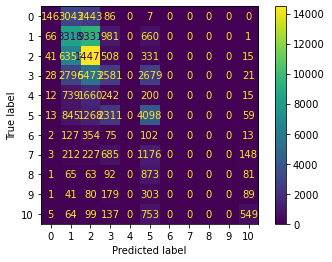

In [15]:
y_pred = model.predict(X_test)
score = 1 - (np.mean(np.abs(y_pred-y_test)))/K
print(f'Accuracy : %.3f' % accuracy_score(y_test, y_pred))
print(f'Score : %.4f' % score)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

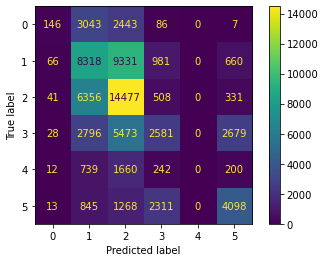

In [16]:
cm_reduced = cm[:6,:6]
cm = confusion_matrix(y_test, y_pred);
disp = ConfusionMatrixDisplay(cm_reduced)
disp.plot();

Results Similar, accuracy is slightly lower

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping


[Back to top](#Content:)


<a id='part4'></a>

# Part 4 -   ANN with one Hidden Layer

### Model


In [ ]:
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(11,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
r = model.fit(X_train,y_train,verbose=1, callbacks=[monitor],validation_split=0.2, epochs=30)



2021-12-19 20:39:58.131757: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-19 20:39:58.132514: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                400       
_________________________________________________________________
dense_1 (Dense)              (None, 11)                187       
Total params: 587
Trainable params: 587
Non-trainable params: 0
_________________________________________________________________
Train on 188275 samples, validate on 47069 samples
Epoch 1/30
188275/188275 [==============================] - 7s 38us/sample - loss: 1.6868 - accuracy: 0.3638 - val_loss: 1.6109 - val_accuracy: 0.3854
Epoch 2/30
188275/188275 [==============================] - 7s 35us/sample - loss: 1.6015 - accuracy: 0.3899 - val_loss: 1.5948 - val_accuracy: 0.3904
Epoch 3/30
188275/188275 [==============================] - 6s 34us/sample - loss: 1.5878 - accuracy: 0.3937 - val_loss: 1.5852 - val_accuracy: 0.3925
Epoch 4/30
18827

In [49]:
# Prediction
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)

# Computing and printing accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy score: {}".format(accuracy))

y_pred.max() 10
y_pred.min() 0


Results similar to before with less features

## Confusion matrix

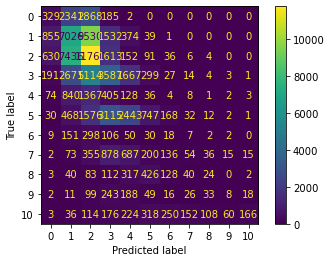

In [53]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

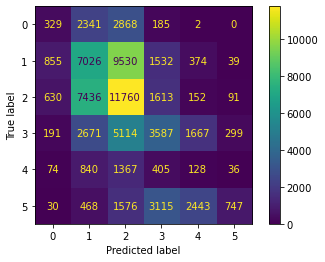

In [54]:
cm_reduced = cm[:6,:6]
cm = confusion_matrix(y_test, y_pred);
disp = ConfusionMatrixDisplay(cm_reduced)
disp.plot();


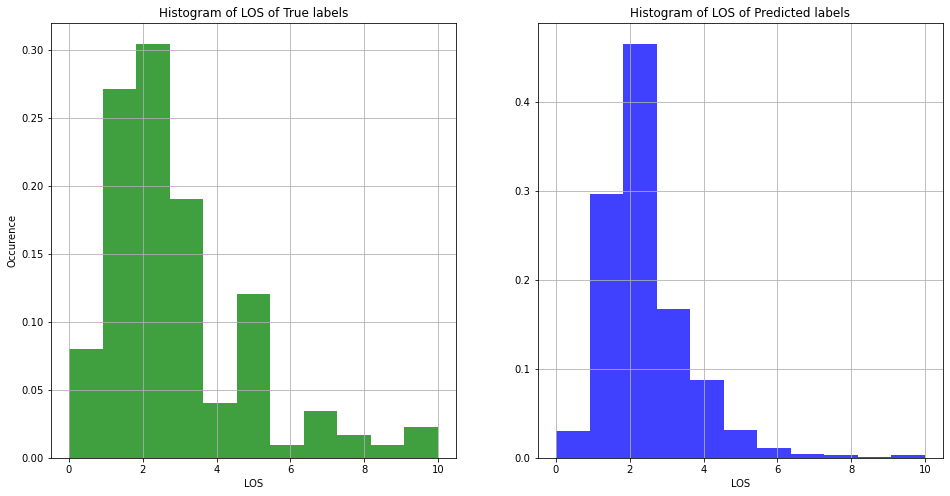

In [55]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(16, 8)
ax1.grid(True)
ax1.hist(y_test, bins=11,  density=True, facecolor='g', alpha=0.75)
ax1.set_title('Histogram of LOS of True labels')
ax1.set_xlabel('LOS')
ax1.set_ylabel('Occurence')

ax2.grid(True)
ax2.hist(y_pred, bins=11,  density=True, facecolor='b', alpha=0.75)
ax2.set_title('Histogram of LOS of Predicted labels')
ax2.set_xlabel('LOS')



plt.show()

When we explore the histogram, the model shows also the same issues showed by linear regression

[Back to top](#Content:)


<a id='part7'></a>

# Part 7 -   Regression with two Hidden Layers

In [56]:
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(24, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='loss', min_delta=1e-1, patience=5, verbose=1, mode='auto')

r = model.fit(X_train,y_train,callbacks=[monitor],validation_split=0.25,verbose=1,epochs=30)

Train on 176508 samples, validate on 58836 samples
Epoch 1/30
176508/176508 [==============================] - 7s 38us/sample - loss: 2.8206 - val_loss: 2.6018
Epoch 2/30
176508/176508 [==============================] - 6s 36us/sample - loss: 2.5754 - val_loss: 2.5228
Epoch 3/30
176508/176508 [==============================] - 6s 34us/sample - loss: 2.5294 - val_loss: 2.5275
Epoch 4/30
176508/176508 [==============================] - 6s 34us/sample - loss: 2.5128 - val_loss: 2.4946
Epoch 5/30
176508/176508 [==============================] - 6s 34us/sample - loss: 2.4991 - val_loss: 2.4752
Epoch 6/30
176508/176508 [==============================] - 6s 34us/sample - loss: 2.4870 - val_loss: 2.4717
Epoch 7/30
176508/176508 [==============================] - 6s 35us/sample - loss: 2.4767 - val_loss: 2.4688
Epoch 00007: early stopping


In [57]:
y_pred = cat(y_pred)

accuracy = accuracy_score(y_pred, y_test)
score = 1 - (np.mean(np.abs(y_pred-y_test)))/K
error = np.sqrt(mean_squared_error(y_pred,y_test))
mean = np.mean(y_test)

print('mean y_test: %.2f' % mean)
print('RMSE : %.2f' % error)
print(f'Accuracy : %.3f' % accuracy)
print(f'Score : %.4f' % score)

mean y_test: 2.69
RMSE : 1.77
Accuracy : 0.304
Score : 0.8782


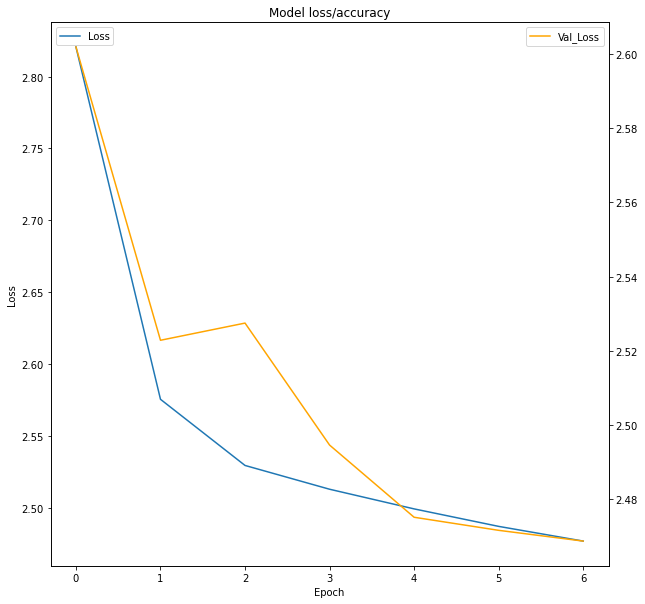

In [58]:
# Plotting
plt.figure(figsize=(10,10))

plt.plot(r.history['loss'])
plt.title('Model loss/accuracy')
plt.ylabel('Loss')
plt.legend(['Loss'], loc='upper left')
plt.xlabel('Epoch')


plt2=plt.twinx()
plt2.plot(r.history['val_loss'], color='orange')
plt2.legend(['Val_Loss'], loc='upper right')

plt.show()

## Confusion Matrix

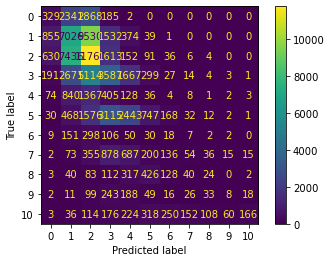

In [59]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

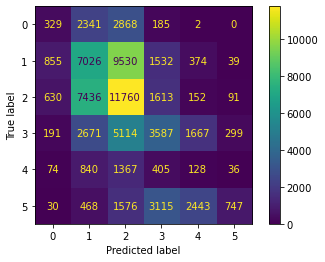

In [60]:
cm_reduced = cm[:6,:6]
cm = confusion_matrix(y_test, y_pred);
disp = ConfusionMatrixDisplay(cm_reduced)
disp.plot();


Same problem again

[Back to top](#Content:)


<a id='part8'></a>

# Part 8 -   Regression with three Hidden Layers

## Model

In [61]:
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='loss', min_delta=1e-2, patience=5, verbose=1, mode='auto')
r = model.fit(X_train,y_train,callbacks=[monitor],validation_split=0.25,verbose=1,epochs=30)

Train on 176508 samples, validate on 58836 samples
Epoch 1/30
176508/176508 [==============================] - 10s 57us/sample - loss: 3.0070 - val_loss: 2.6220
Epoch 2/30
176508/176508 [==============================] - 9s 53us/sample - loss: 2.6821 - val_loss: 2.5612
Epoch 3/30
176508/176508 [==============================] - 9s 53us/sample - loss: 2.6281 - val_loss: 2.5638
Epoch 4/30
176508/176508 [==============================] - 9s 53us/sample - loss: 2.5952 - val_loss: 2.5580
Epoch 5/30
176508/176508 [==============================] - 9s 53us/sample - loss: 2.5782 - val_loss: 2.5712
Epoch 6/30
176508/176508 [==============================] - 9s 53us/sample - loss: 2.5637 - val_loss: 2.5454
Epoch 7/30
176508/176508 [==============================] - 9s 53us/sample - loss: 2.5614 - val_loss: 2.5166
Epoch 8/30
176508/176508 [==============================] - 9s 53us/sample - loss: 2.5450 - val_loss: 2.5243
Epoch 9/30
176508/176508 [==============================] - 9s 53us/sample -

In [62]:
y_pred = cat(y_pred)

accuracy = accuracy_score(y_pred, y_test)
score = 1 - (np.mean(np.abs(y_pred-y_test)))/K
error = np.sqrt(mean_squared_error(y_pred,y_test))
mean = np.mean(y_test)

print('mean y_test: %.2f' % mean)
print('RMSE : %.2f' % error)
print(f'Accuracy : %.3f' % accuracy)
print(f'Score : %.4f' % score)

mean y_test: 2.69
RMSE : 1.77
Accuracy : 0.304
Score : 0.8782


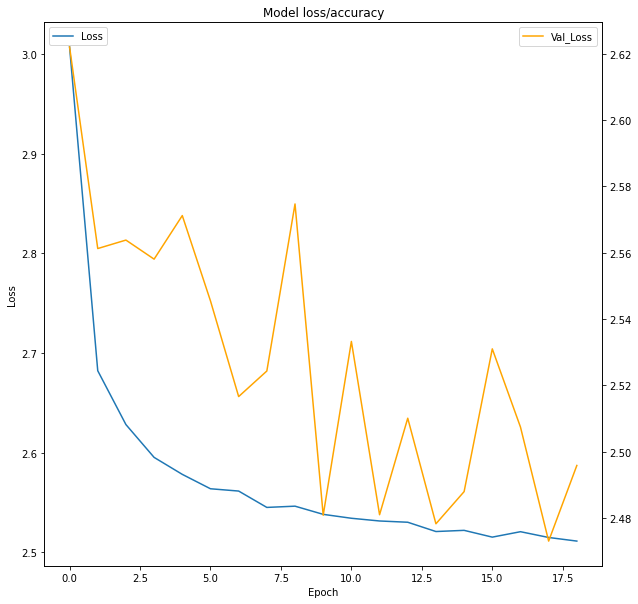

In [63]:
# Plotting
plt.figure(figsize=(10,10))

plt.plot(r.history['loss'])
plt.title('Model loss/accuracy')
plt.ylabel('Loss')
plt.legend(['Loss'], loc='upper left')
plt.xlabel('Epoch')


plt2=plt.twinx()
plt2.plot(r.history['val_loss'], color='orange')
plt2.legend(['Val_Loss'], loc='upper right')

plt.show()

### Confusion Matrix

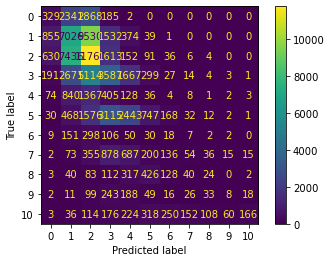

In [64]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

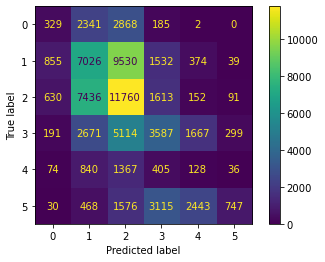

In [65]:
cm_reduced = cm[:6,:6]
cm = confusion_matrix(y_test, y_pred);
disp = ConfusionMatrixDisplay(cm_reduced)
disp.plot();

## Conclusion